In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt

alg_accuracy_scores = {}
df = pd.read_csv('wisc_bc_data.csv')
#print(df.isnull().sum())

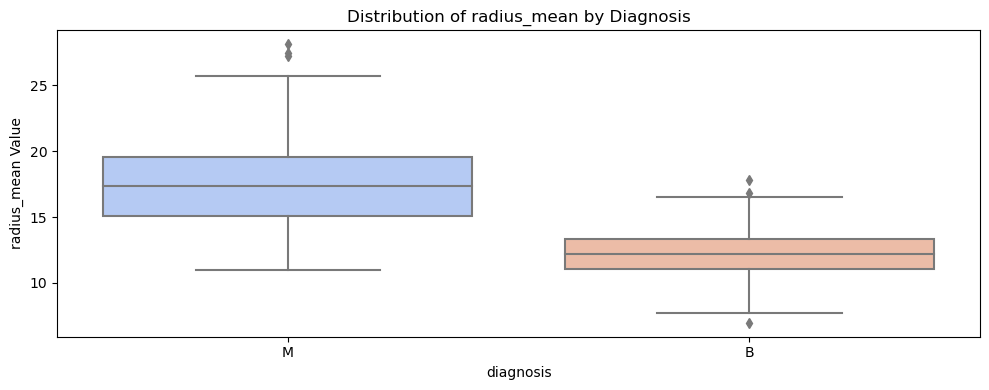

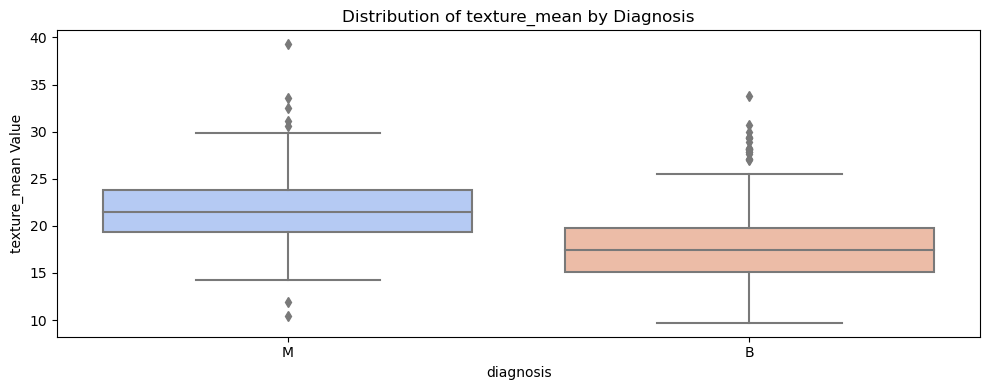

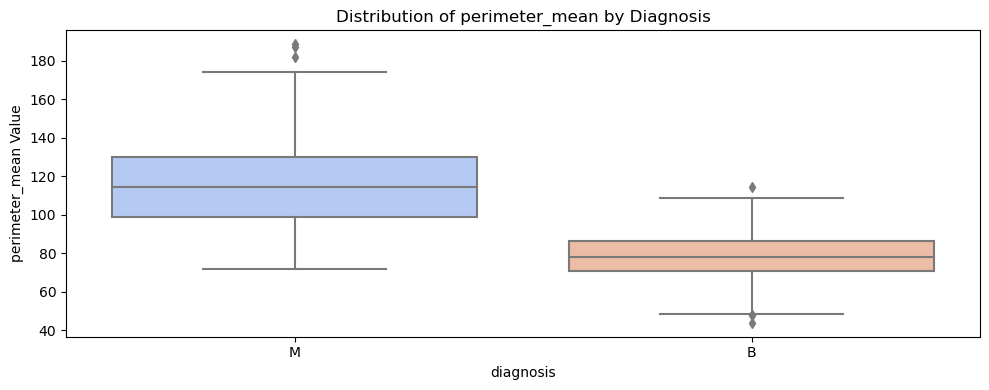

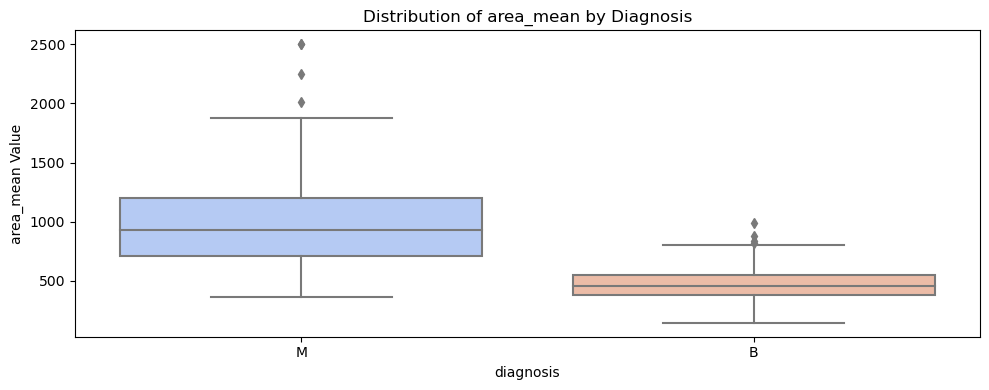

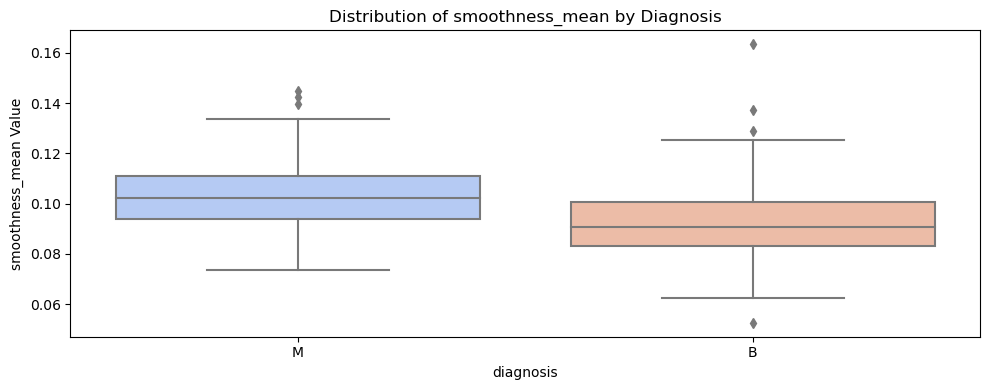

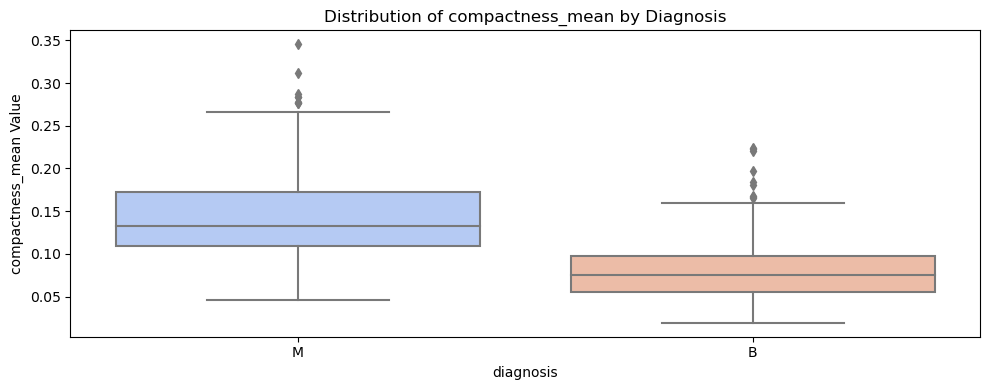

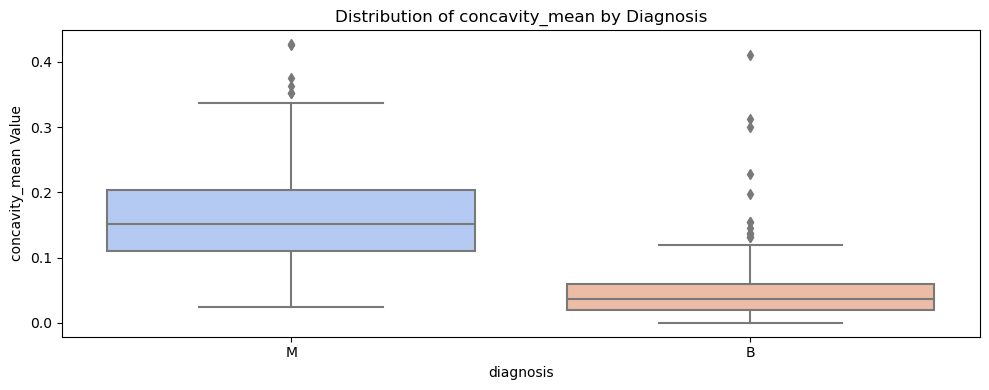

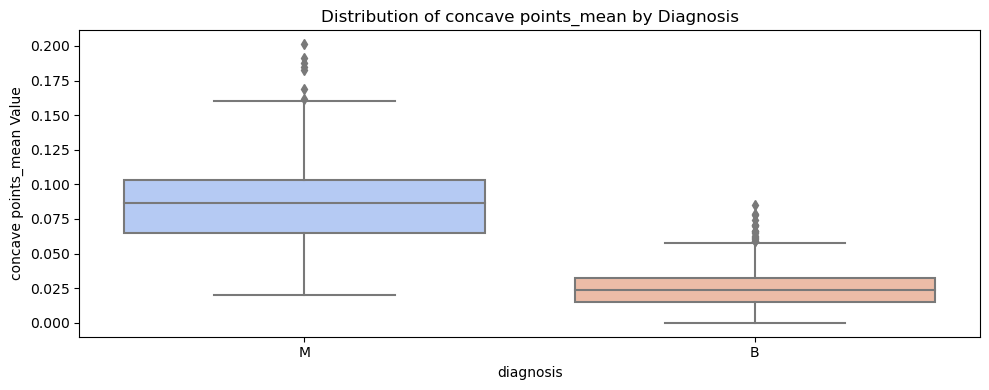

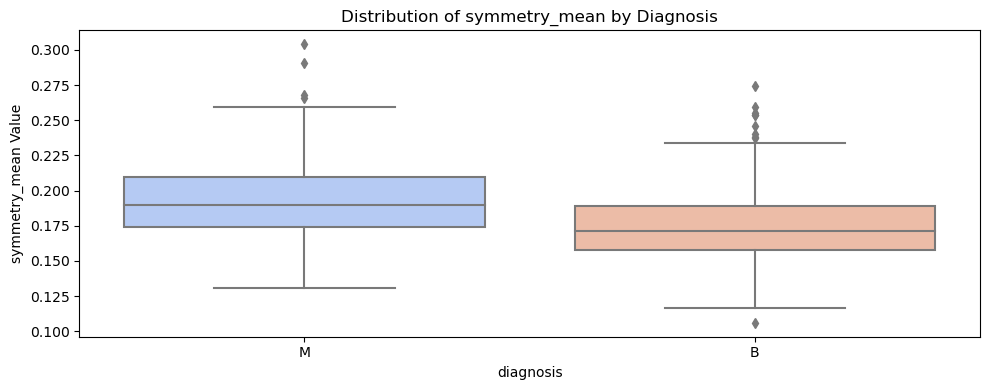

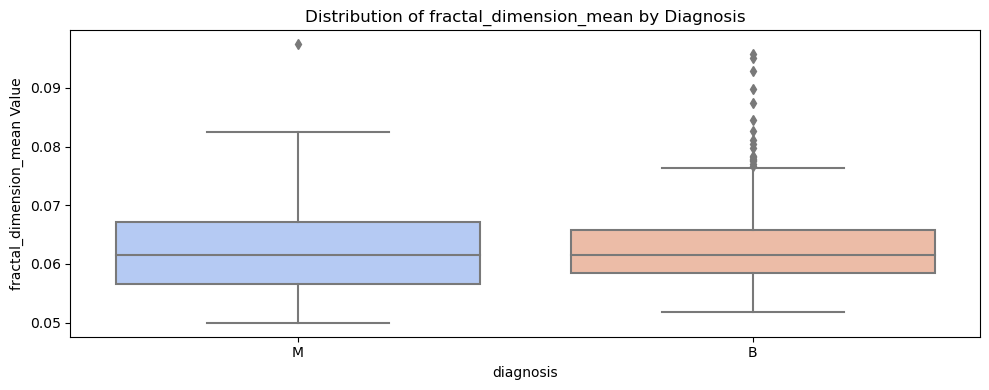

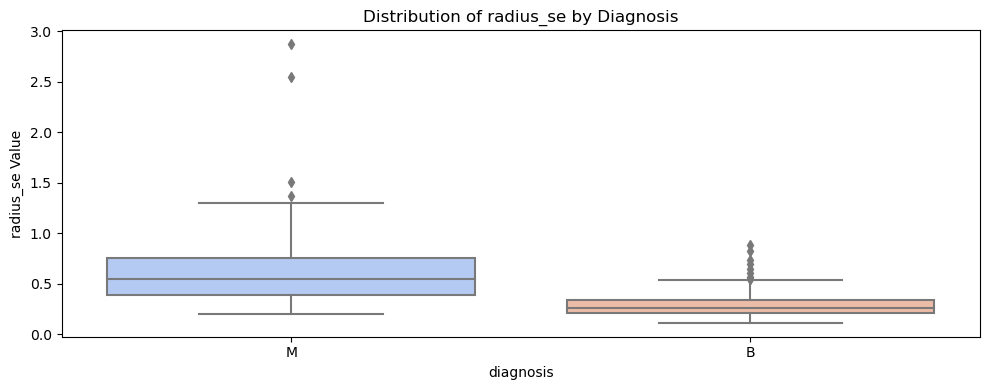

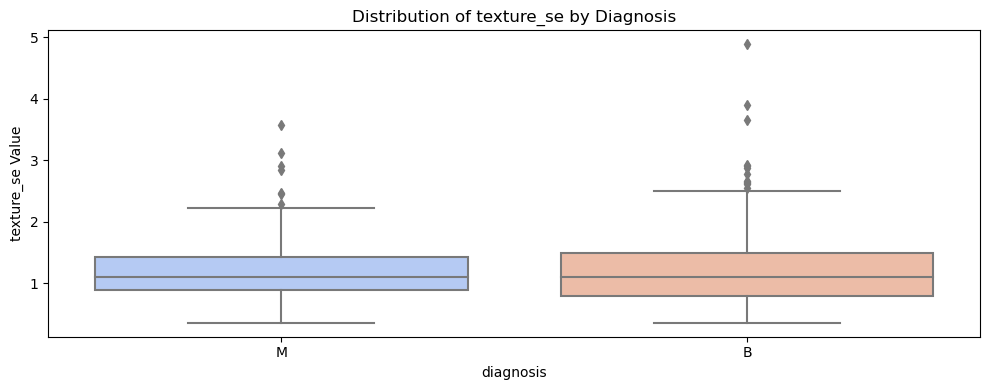

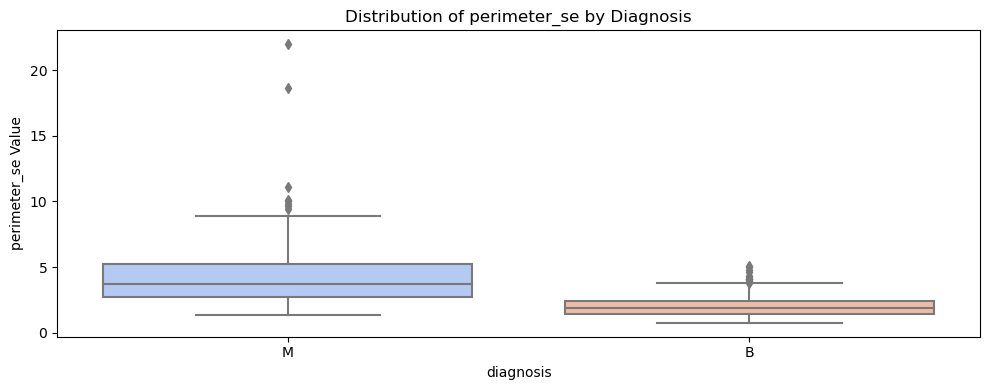

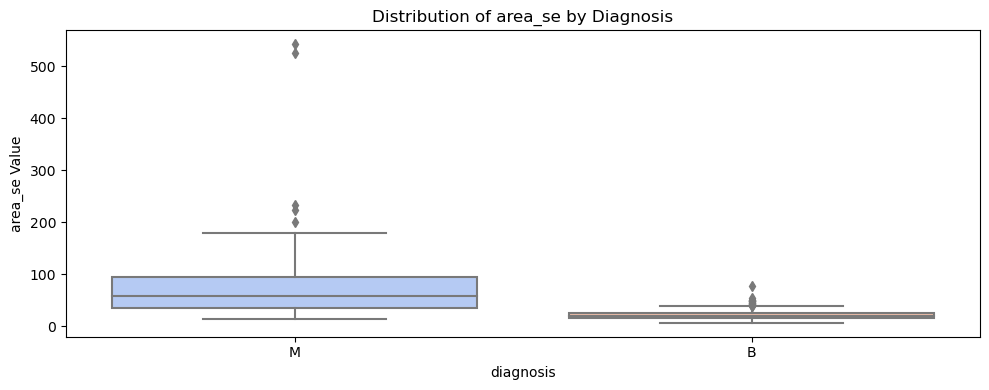

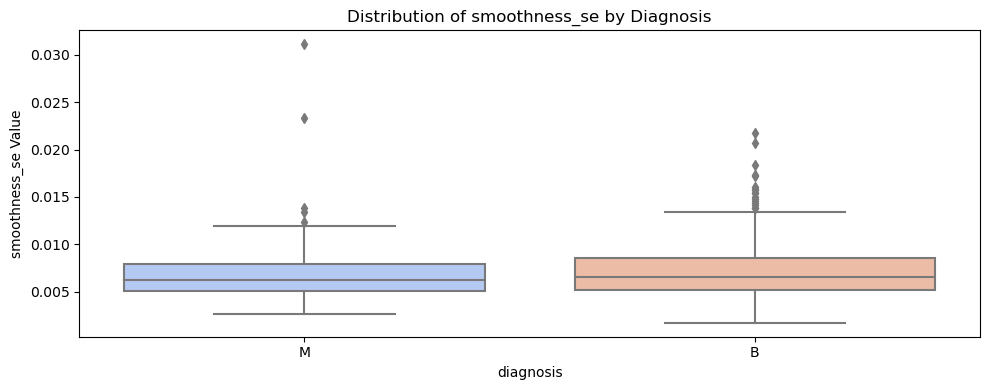

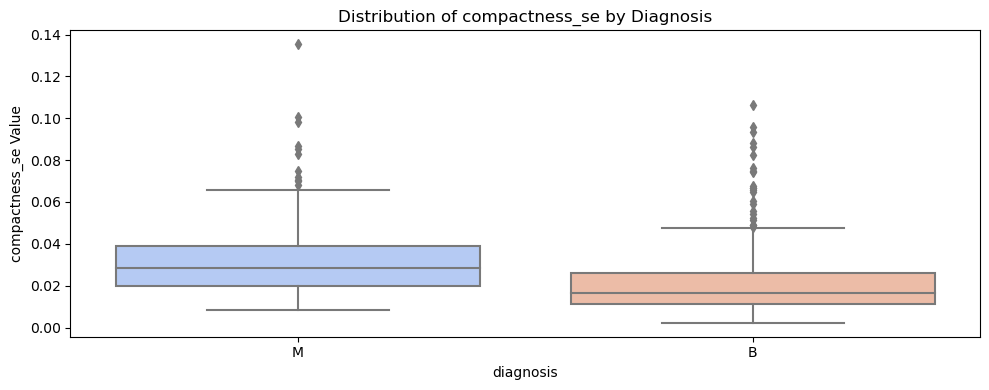

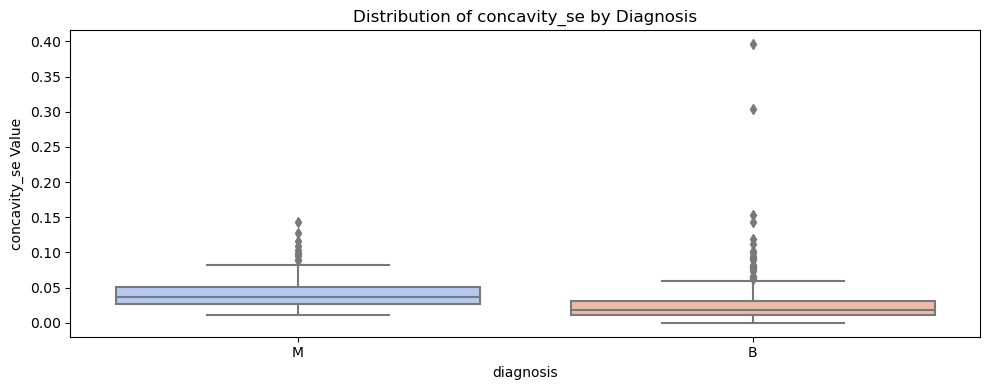

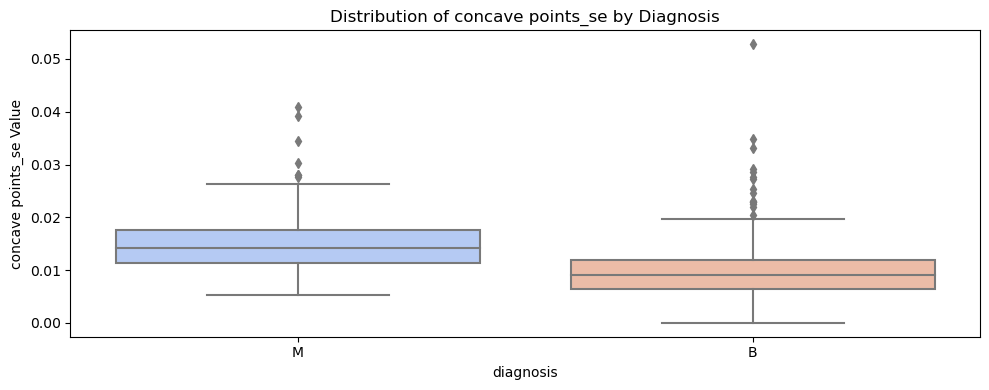

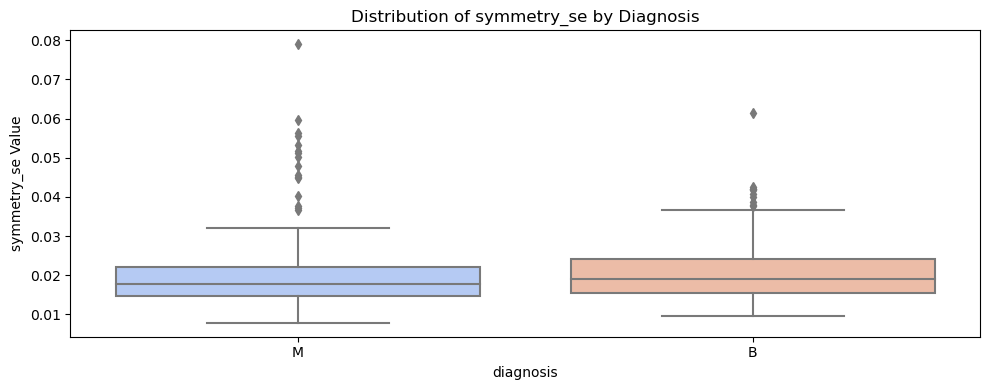

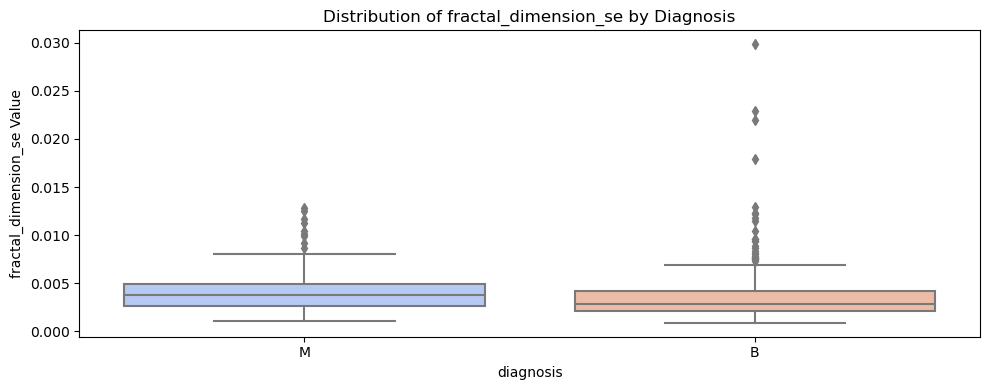

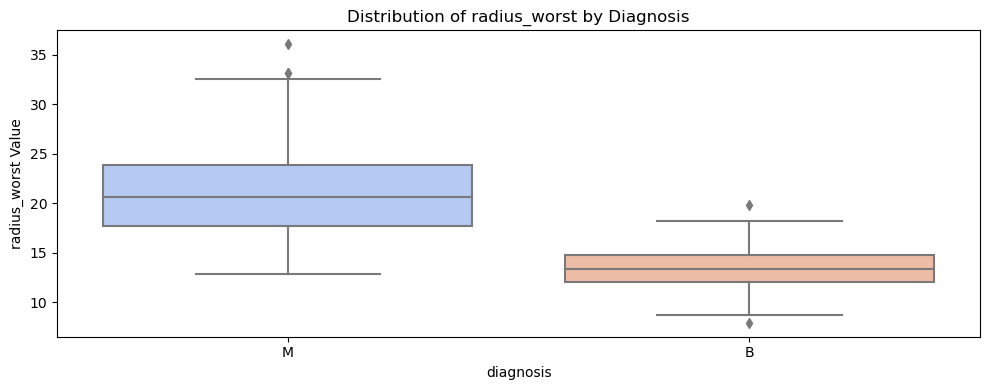

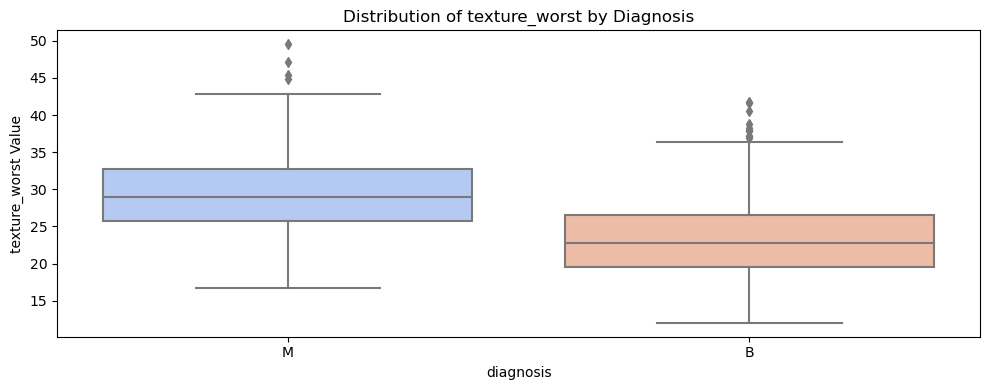

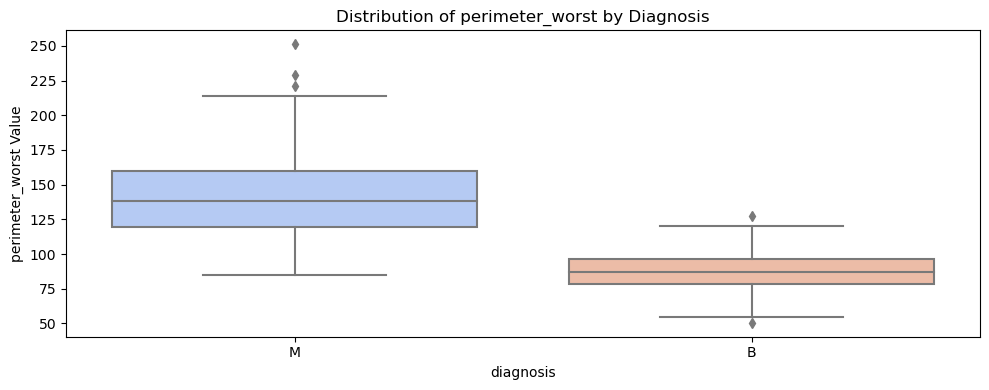

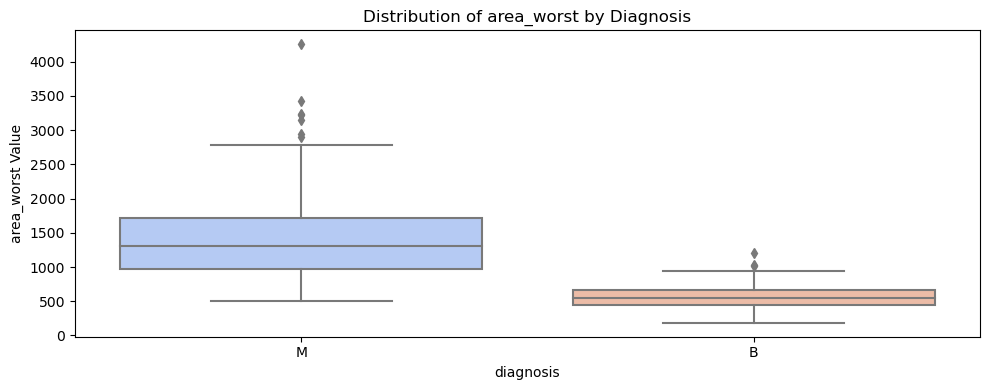

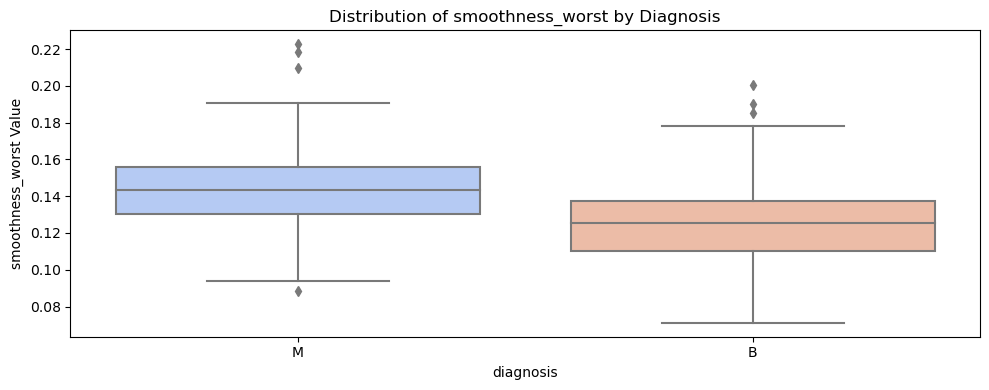

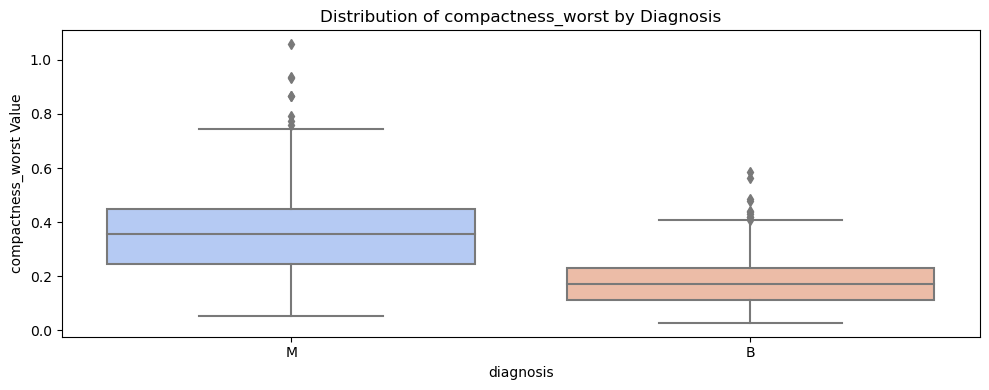

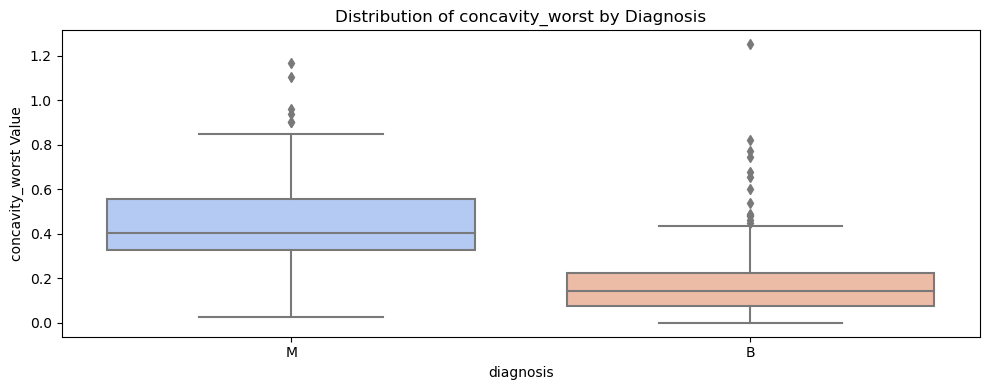

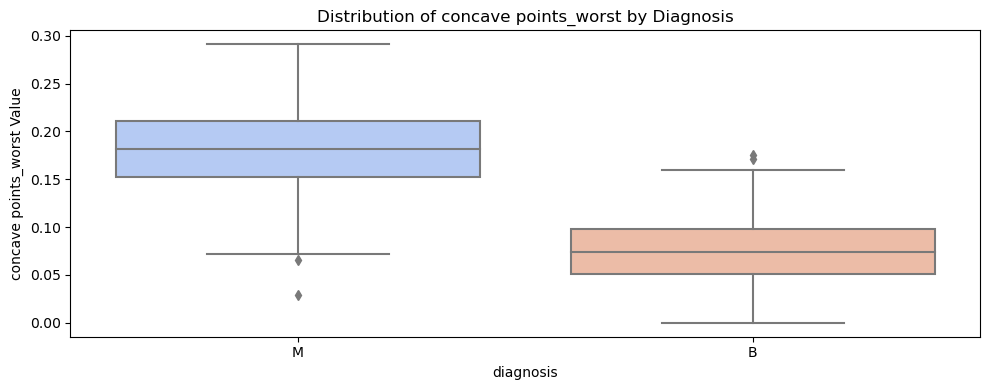

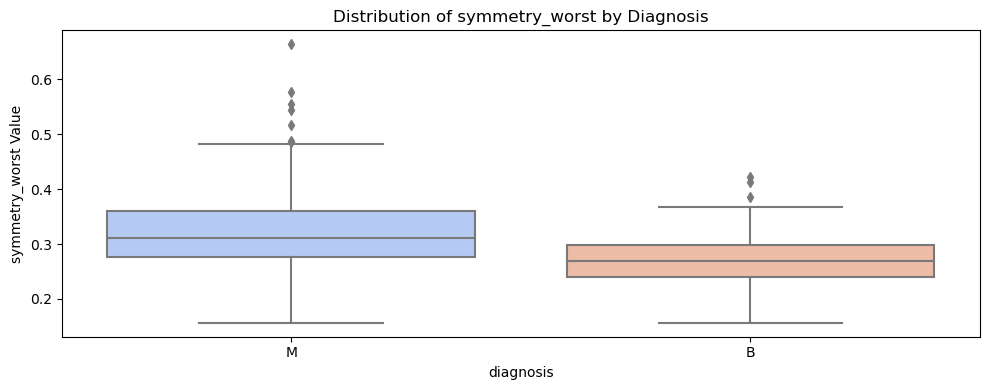

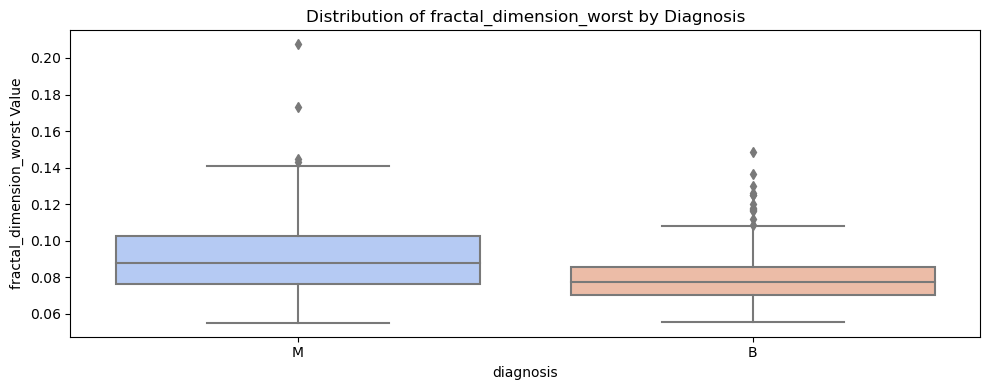

In [2]:
#ex 2
#make plots of atributes according to target attribute (diagnosis)

#Diagnosis codes:
#M -> malignant cell
#B -> belignent cell

attributes_lst = df.columns.to_list()
attributes_lst.remove('id')
attributes_lst.remove('diagnosis')



# Creating the multiple box plots
for attribute in attributes_lst:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x='diagnosis', y=attribute, palette="coolwarm")
    plt.title(f"Distribution of {attribute} by Diagnosis")
    plt.ylabel(f"{attribute} Value")
    plt.tight_layout()
    plt.show()

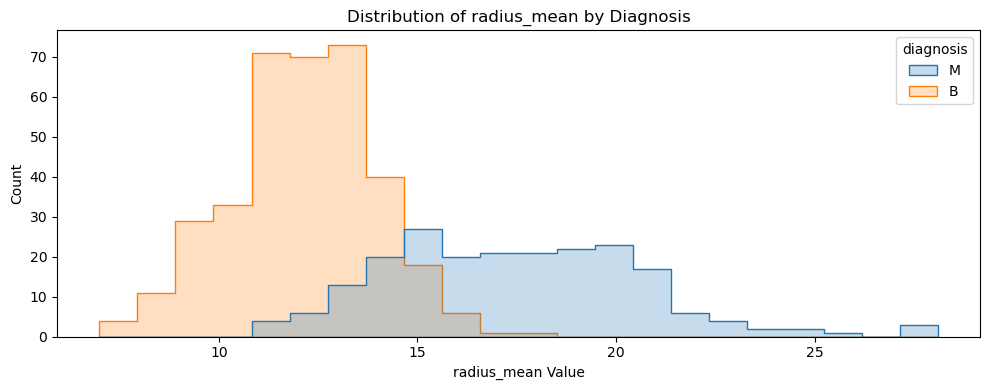

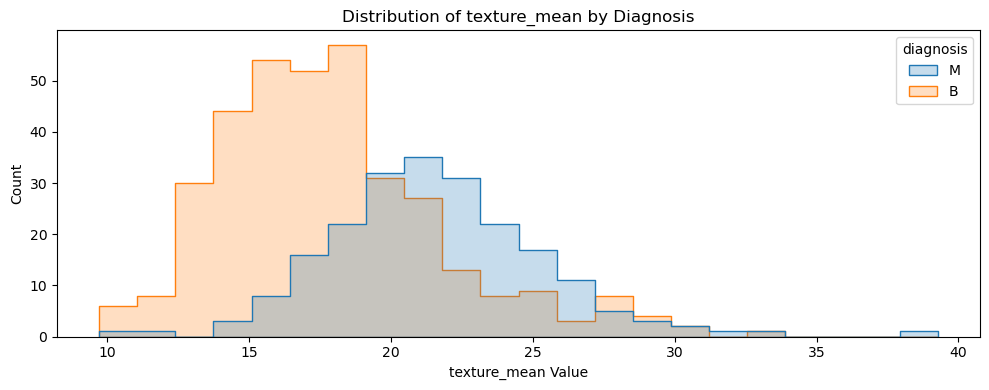

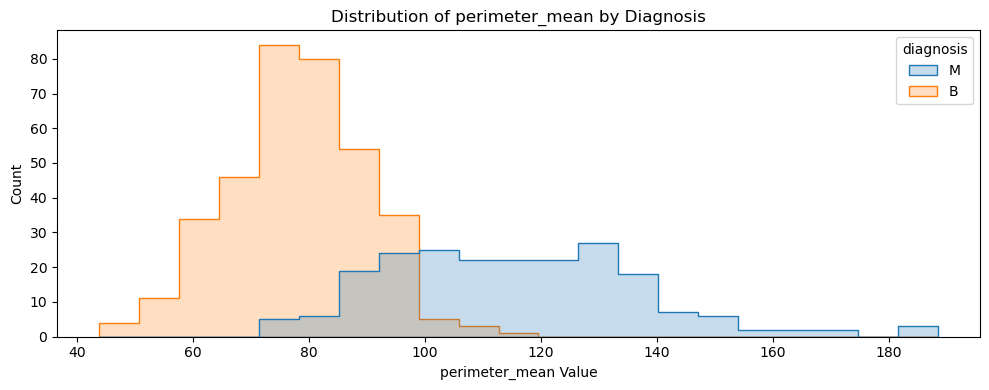

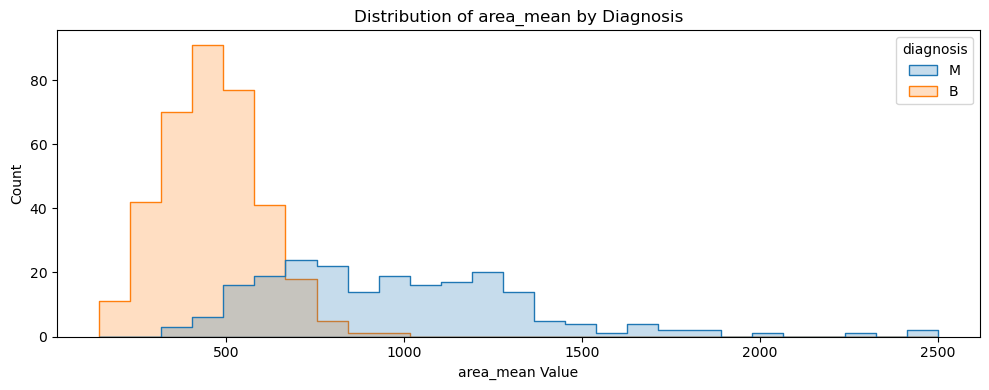

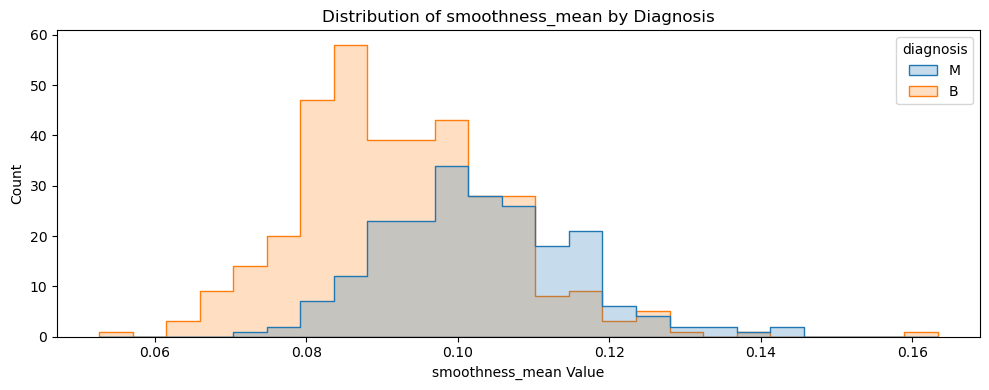

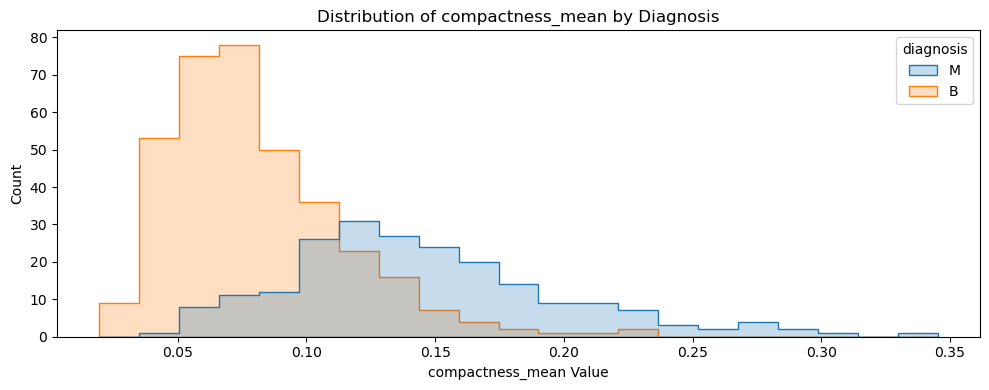

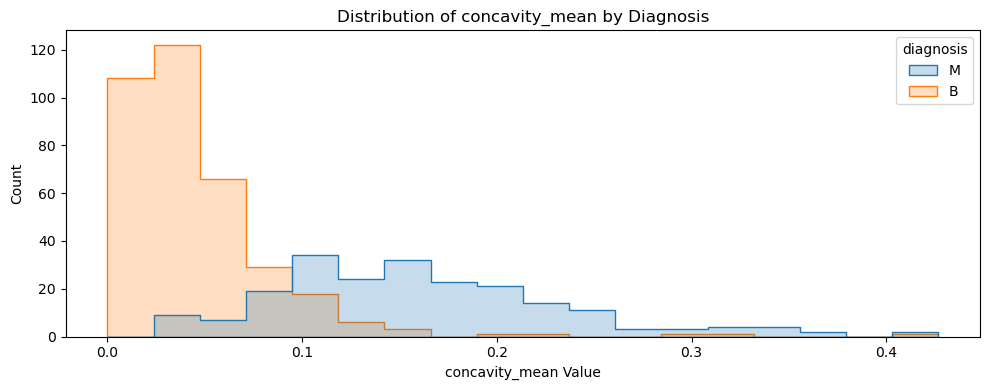

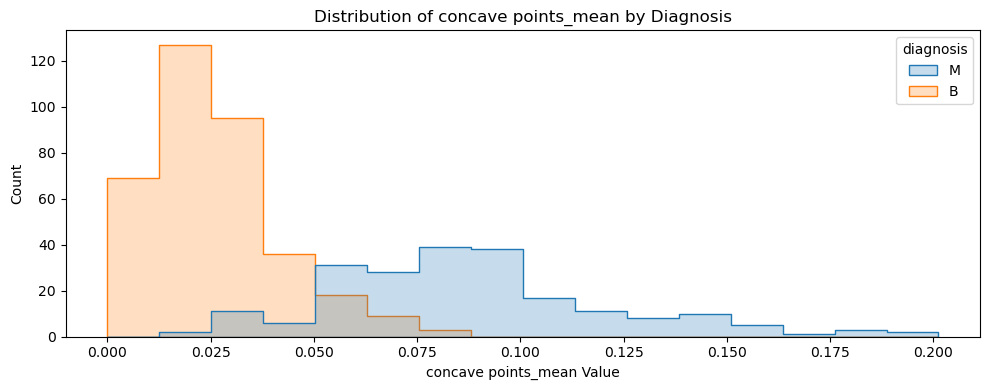

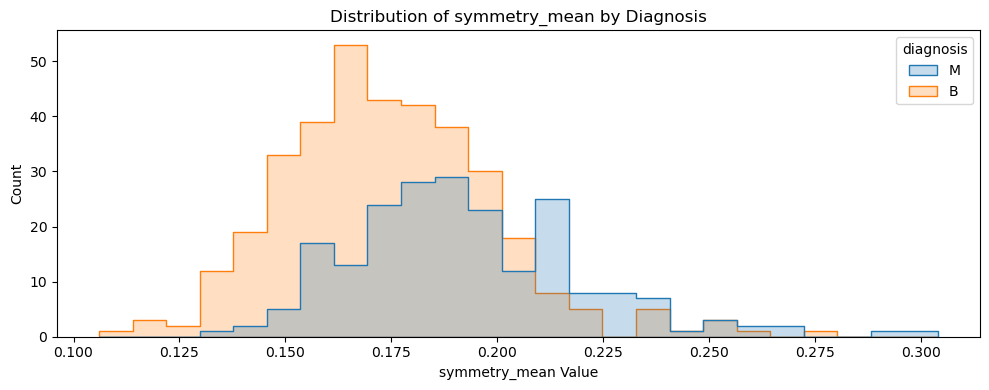

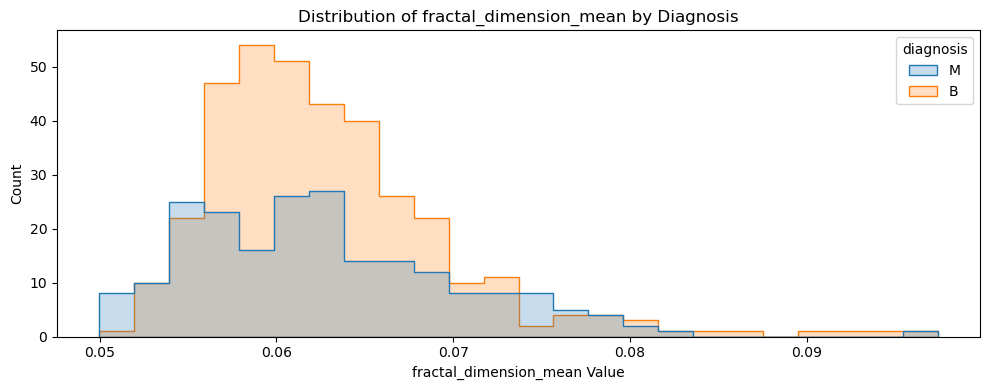

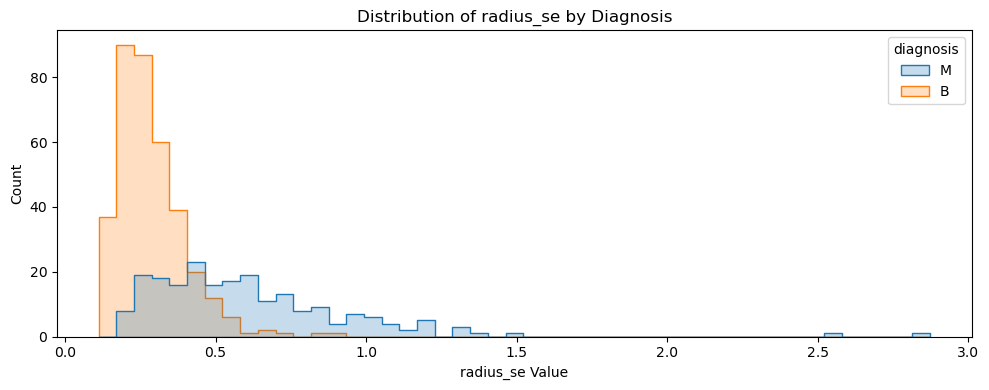

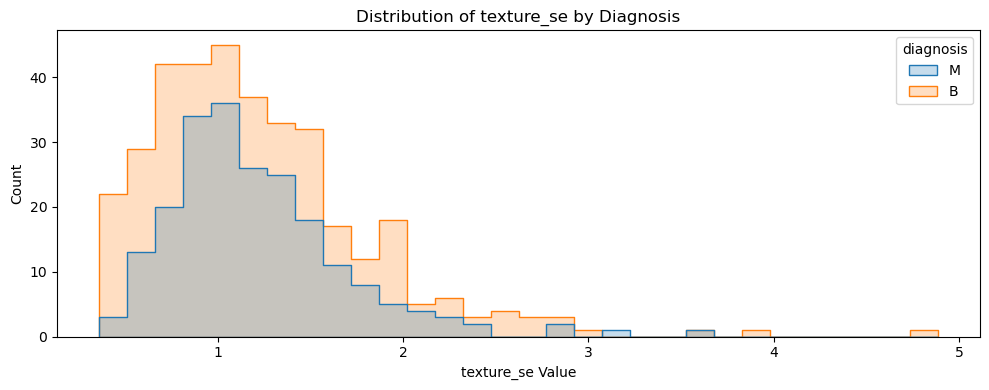

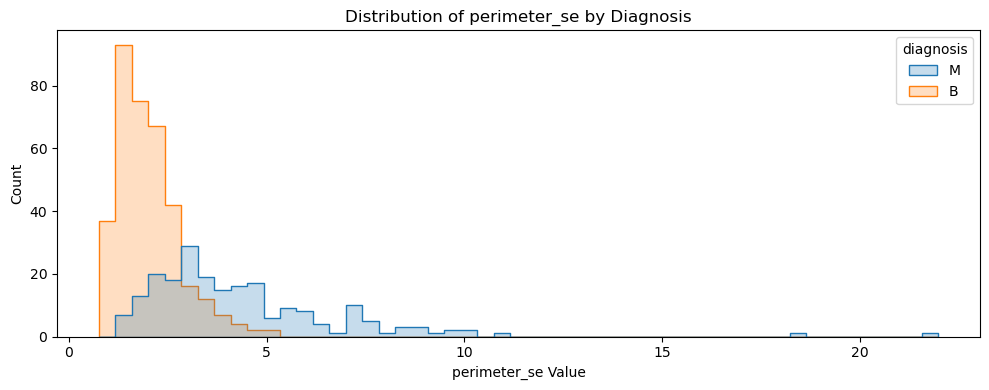

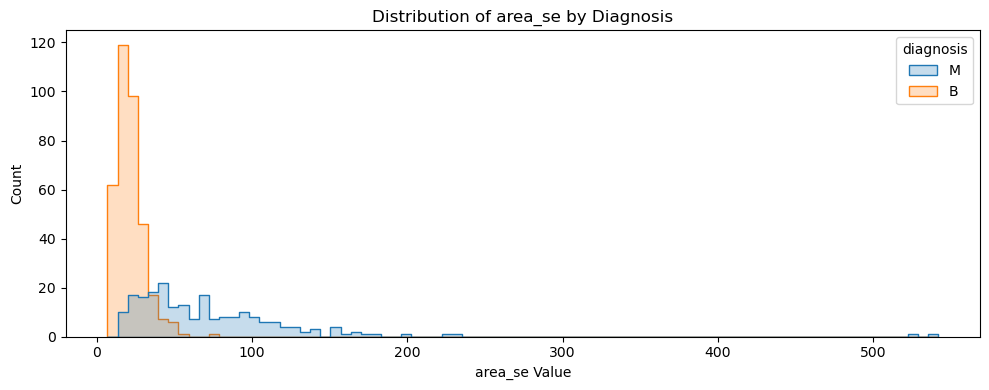

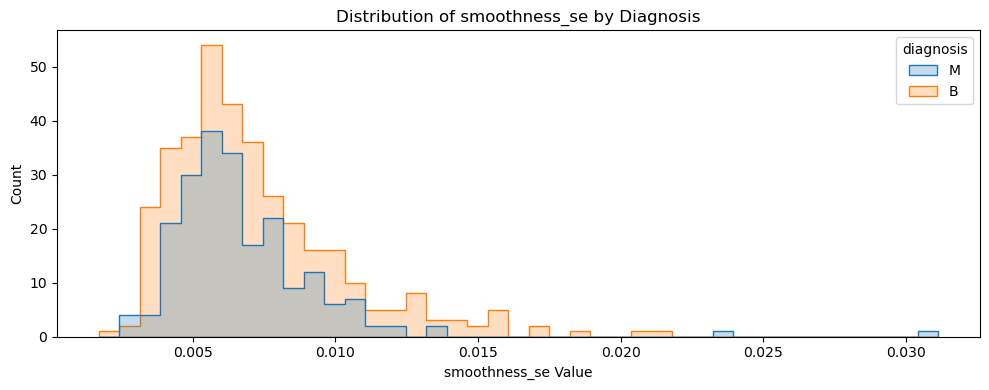

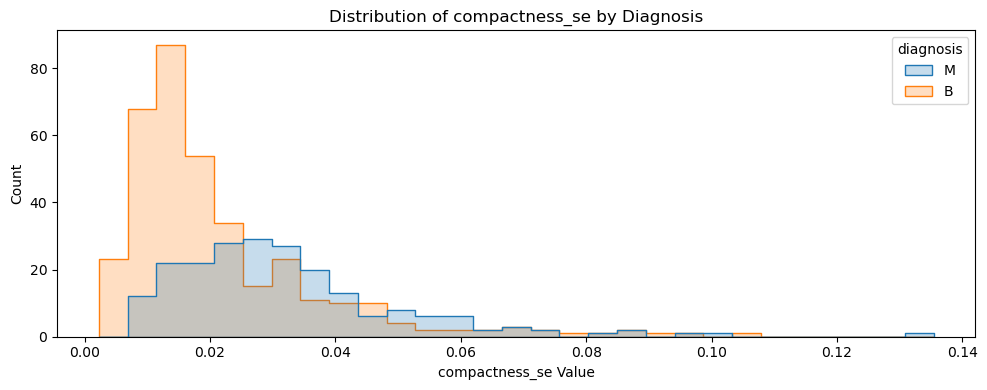

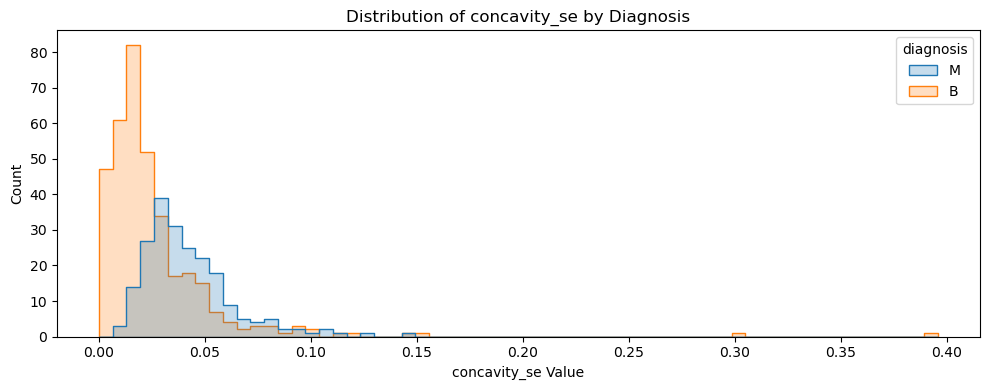

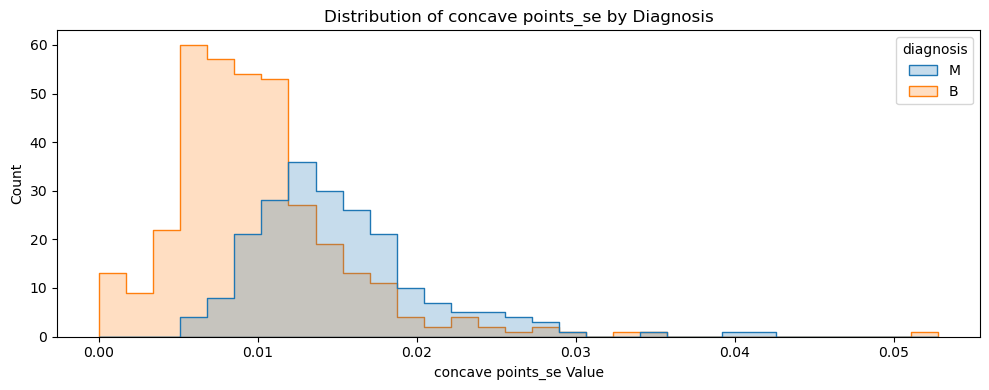

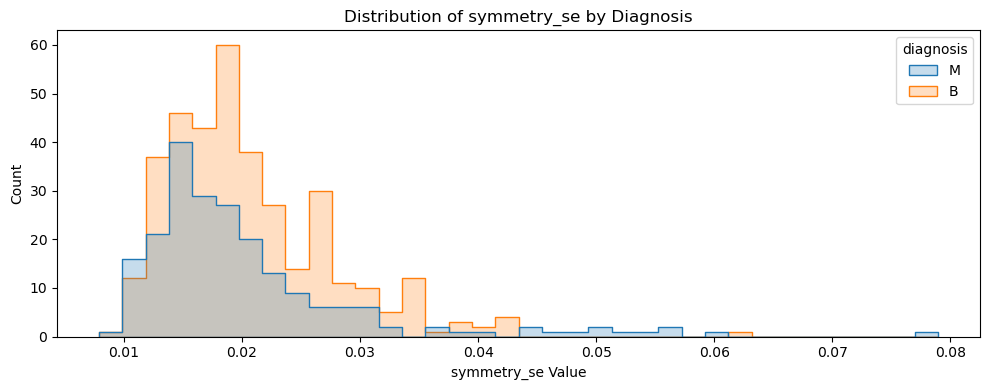

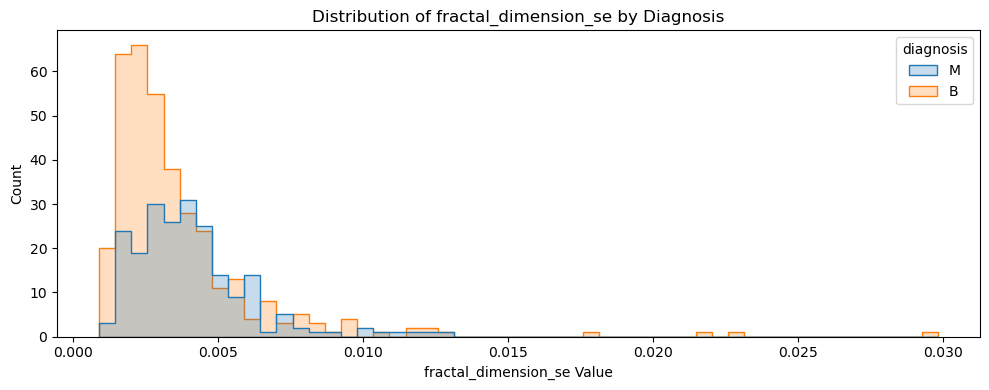

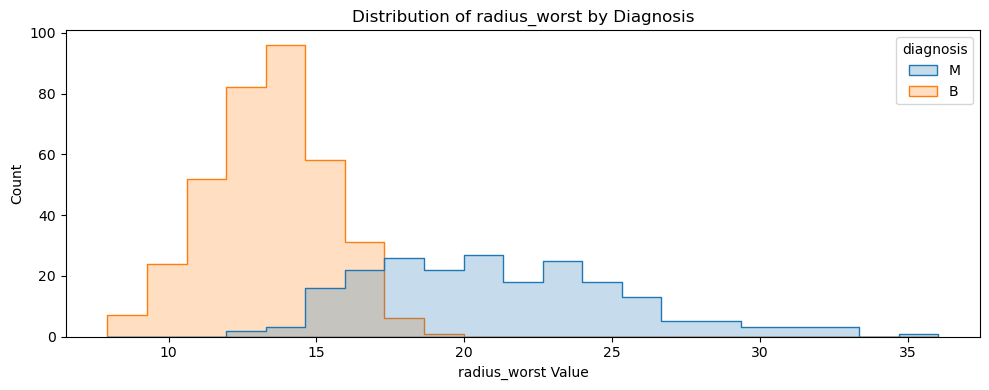

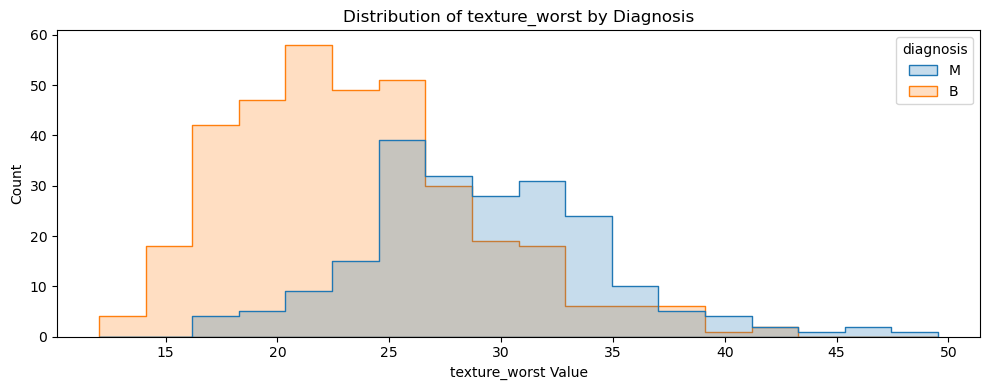

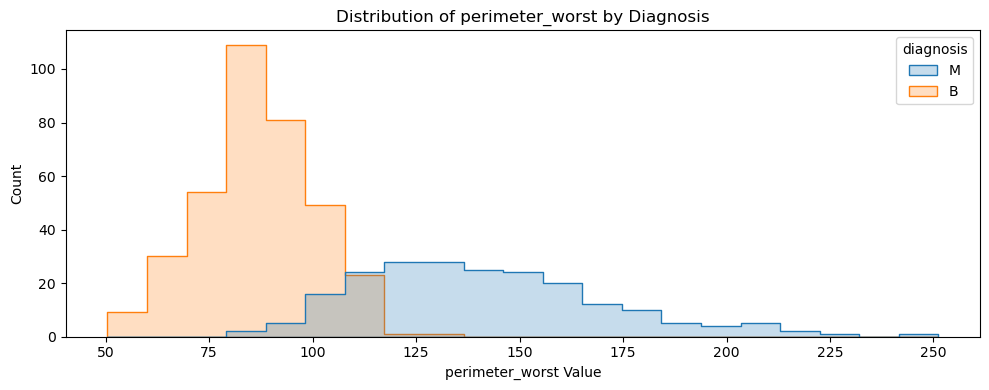

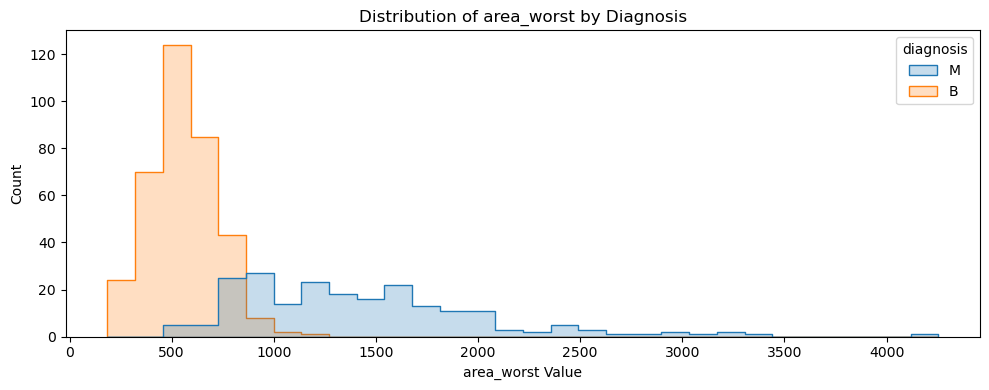

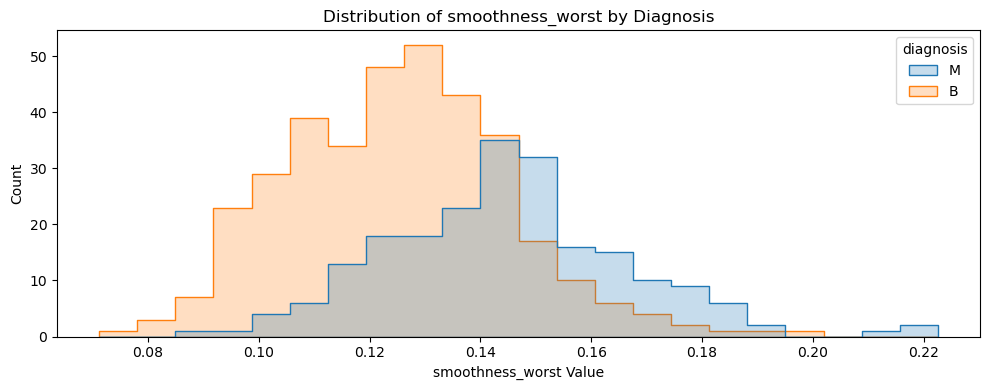

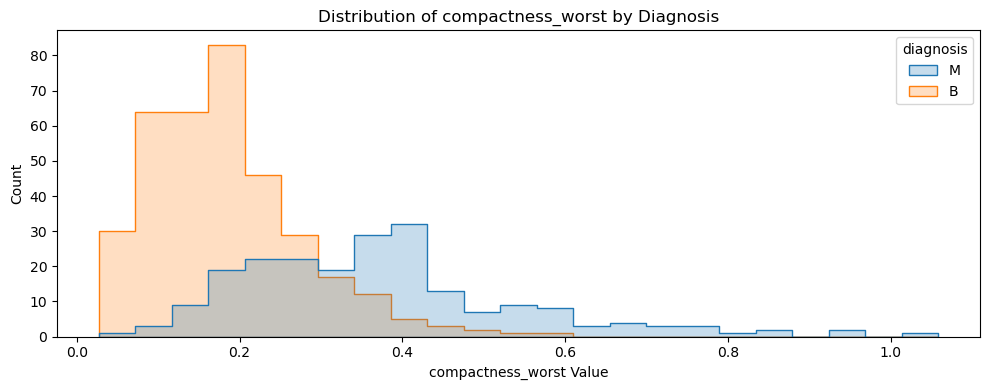

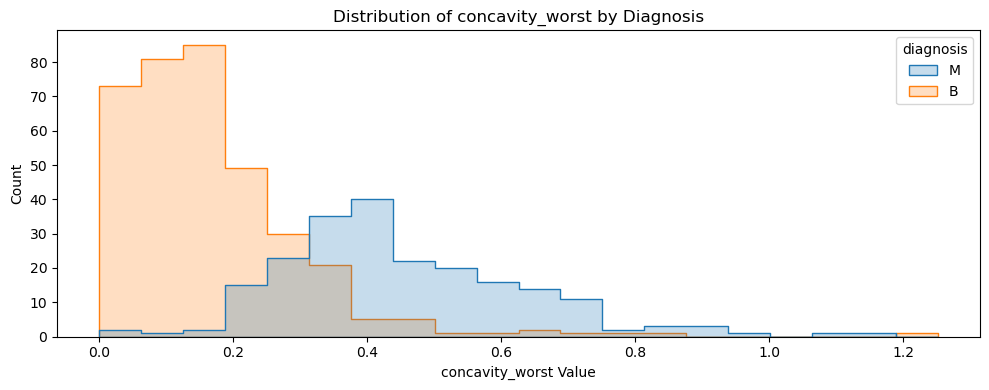

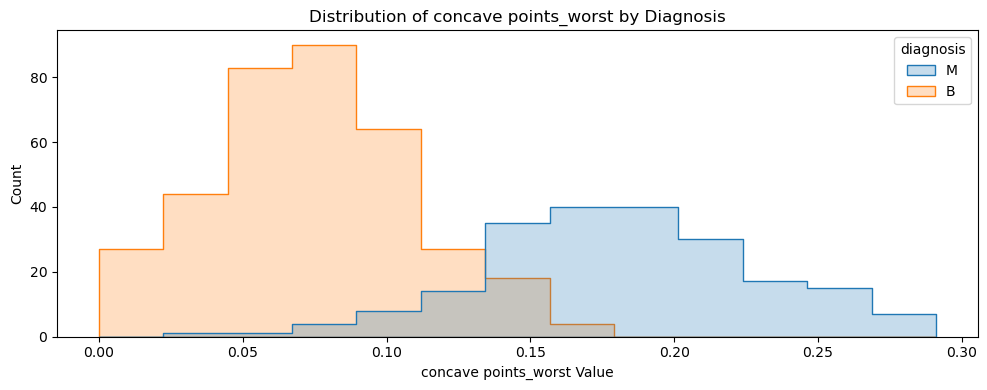

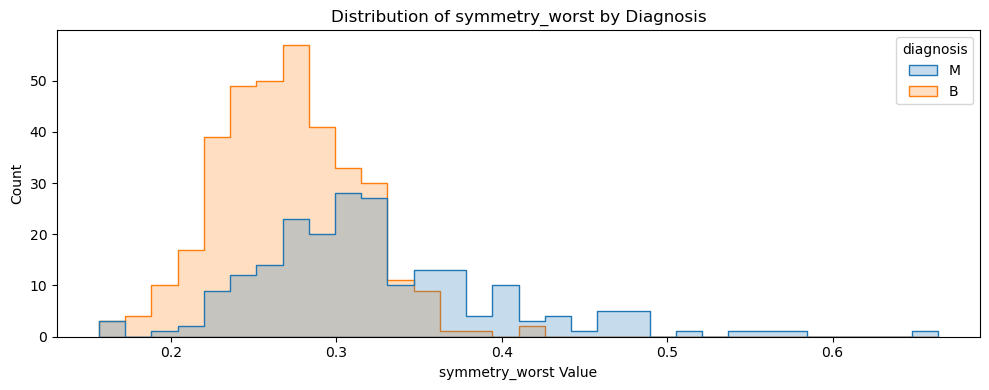

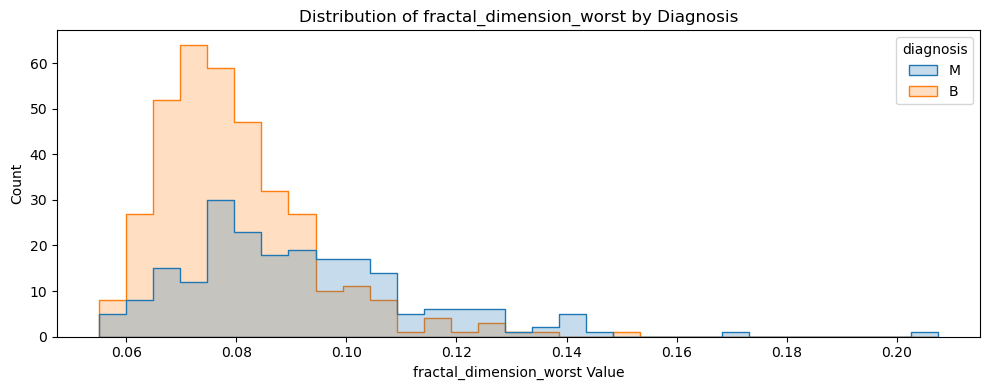

In [3]:
#ex 2 -> histograms

# Creating the multiple histograms
for attribute in attributes_lst:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=attribute, hue='diagnosis', element="step", common_norm=False)
    plt.title(f"Distribution of {attribute} by Diagnosis")
    plt.xlabel(f"{attribute} Value")
    plt.tight_layout()
    plt.show()

In [4]:
#ex3-> make prediction Models
# i) Naive Bayes

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


#a coluna id é irrelevante po modelo, logo vamos ignorá-la

df = df.drop(columns=['id'])

#x - features
#y- target variable
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

#fazer o split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#treinar o modelo de bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#fazer a previsões
y_pred = gnb.predict(X_test)


#avaliar o modelo
# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 97.37%
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        71
           M       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [5]:

#ex3-> make prediction Models
# ii) K-neares Neighbours

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report


X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# 1. Train the KNeighbors Classifier
knn = KNeighborsClassifier() # Using default parameters
knn.fit(X_train, y_train)

# 2. Make Predictions on the Test Set
y_pred = knn.predict(X_test)

# 3. Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print accuracy
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"k-NN Accuracy: {accuracy_knn * 100:.2f}%")

# 4. Calculate Precision, Recall, and F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))

Confusion Matrix:
[[71  0]
 [ 5 38]]
k-NN Accuracy: 95.61%

Classification Report:
              precision    recall  f1-score   support

          No       0.93      1.00      0.97        71
         Yes       1.00      0.88      0.94        43

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [6]:
#ex4

#let's optimize the naive bayes model


from sklearn.model_selection import GridSearchCV

# naive_bayes_params = {
#     'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
# }

gnb = GaussianNB()

gs_naive_bayes = GridSearchCV(gnb, cv=5, param_grid={}, scoring='accuracy', n_jobs=-1)
gs_naive_bayes.fit(X_train, y_train)

print("Best Parameters for Naive Bayes:", gs_naive_bayes.best_params_)

y_pred_gnb = gs_naive_bayes.predict(X_test)
print("Accuracy for Optimized Naive Bayes:", accuracy_score(y_test, y_pred_gnb))

alg_accuracy_scores['Optimized Niave Bayes'] = accuracy_score(y_test, y_pred_gnb)

Best Parameters for Naive Bayes: {}
Accuracy for Optimized Naive Bayes: 0.9736842105263158


In [7]:
#ex4
from sklearn.model_selection import GridSearchCV



#let's optimize the k-nearest neighbours model
knn_params = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
     #'p': [1, 2]  # 1: manhattan_distance, 2: euclidean_distance
}


knn = KNeighborsClassifier()

gs_knn = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)
gs_knn.fit(X_train, y_train)

print("Best Parameters for k-NN:", gs_knn.best_params_)



y_pred_knn = gs_knn.predict(X_test)
print("Accuracy for Optimized k-NN:", accuracy_score(y_test, y_pred_knn))
alg_accuracy_scores['Optimized K-NN'] =accuracy_score(y_test, y_pred_knn)

Best Parameters for k-NN: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for Optimized k-NN: 0.9473684210526315


In [8]:
#ex5
#i) and ii)
from sklearn.ensemble import VotingClassifier


gnb_optimized = GaussianNB(**gs_naive_bayes.best_params_)
knn_optimized = KNeighborsClassifier(**gs_knn.best_params_)



majority_voting_classifier = VotingClassifier(estimators=[
    ('gnb', gnb_optimized), 
    ('knn', knn_optimized)
], voting='hard')

majority_voting_classifier.fit(X_train, y_train)

weights = [2, 1]  # Example weights: 2 for Gaussian Naive Bayes and 1 for k-NN

weighted_voting_classifier = VotingClassifier(estimators=[
    ('gnb', gnb_optimized), 
    ('knn', knn_optimized)
], voting='soft', weights=weights)

weighted_voting_classifier.fit(X_train, y_train)


y_pred_majority = majority_voting_classifier.predict(X_test)
print("Accuracy for Majority Voting:", accuracy_score(y_test, y_pred_majority))

y_pred_weighted = weighted_voting_classifier.predict(X_test)
print("Accuracy for Weighted Majority Voting:", accuracy_score(y_test, y_pred_weighted))

alg_accuracy_scores['Majority Voting'] = accuracy_score(y_test, y_pred_majority)
alg_accuracy_scores['Weighted Majority Voting'] = accuracy_score(y_test, y_pred_weighted)


Accuracy for Majority Voting: 0.9473684210526315
Accuracy for Weighted Majority Voting: 0.9649122807017544


In [9]:
# #teste
# gnb_optimized.fit(X_train, y_train)
# knn_optimized.fit(X_train, y_train)

# y_pred_gnb = gnb_optimized.predict(X_test)
# y_pred_knn = knn_optimized.predict(X_test)

# from sklearn.metrics import accuracy_score

# accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
# accuracy_knn = accuracy_score(y_test, y_pred_knn)

# print(f"Accuracy for Optimized Gaussian Naive Bayes: {accuracy_gnb * 100:.2f}%")
# print(f"Accuracy for Optimized k-NN: {accuracy_knn * 100:.2f}%")


In [10]:
#ex6
#i)
#Usar stacking -> no fundo estamos a criar um novo modelo ( treinar), através da combinação das previsões dos modelos usados

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

gnb_optimized = GaussianNB(**gs_naive_bayes.best_params_)
knn_optimized = KNeighborsClassifier(**gs_knn.best_params_)


stacked_classifier = StackingClassifier(
    estimators=[
        ('gnb', gnb_optimized),
        ('knn', knn_optimized)
    ],
    final_estimator=LogisticRegression()
)

stacked_classifier.fit(X_train, y_train)

y_pred_stacked = stacked_classifier.predict(X_test)
print("Accuracy for Stacked Classifier:", accuracy_score(y_test, y_pred_stacked))

alg_accuracy_scores['Stacked Classifier'] =  accuracy_score(y_test, y_pred_stacked)

Accuracy for Stacked Classifier: 0.9649122807017544


In [11]:

#ii) support Vector Machines

from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

gnb_optimized = GaussianNB(**gs_naive_bayes.best_params_)
knn_optimized = KNeighborsClassifier(**gs_knn.best_params_)

stacked_classifier_svm = StackingClassifier(
    estimators=[
        ('gnb', gnb_optimized),
        ('knn', knn_optimized)
    ],
    final_estimator=SVC(probability=True)
)

stacked_classifier_svm.fit(X_train, y_train)

y_pred_stacked_svm = stacked_classifier_svm.predict(X_test)
print("Accuracy for Stacked Classifier with SVM:", accuracy_score(y_test, y_pred_stacked_svm))

alg_accuracy_scores['Stacked Classifier with SVM'] =  accuracy_score(y_test, y_pred_stacked_svm)


Accuracy for Stacked Classifier with SVM: 0.9649122807017544


In [12]:
#ex7 
#Bagging:  
#i) BaggingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
base_classifier = DecisionTreeClassifier()

bagging = BaggingClassifier(base_classifier, n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)

y_pred_bagging = bagging.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)

print(f"Accuracy for Bagging Classifier: {accuracy_bagging * 100:.2f}%")

#ii) Random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy for Random Forest: {accuracy_rf * 100:.2f}%")

alg_accuracy_scores['Bagging Classifier'] =  accuracy_bagging
alg_accuracy_scores['Random Forest'] =  accuracy_rf



Accuracy for Bagging Classifier: 95.61%
Accuracy for Random Forest: 96.49%


In [13]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score


#Boosting
#i) Adaboost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)

print(f"Accuracy for AdaBoost: {accuracy_ada * 100:.2f}%")

#ii) Gradient Boosting
gboost = GradientBoostingClassifier(n_estimators=100, random_state=42)
gboost.fit(X_train, y_train)

y_pred_gboost = gboost.predict(X_test)
accuracy_gboost = accuracy_score(y_test, y_pred_gboost)

print(f"Accuracy for Gradient Boosting: {accuracy_gboost * 100:.2f}%")



#iii) XGBoost2
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train_encoded)

y_pred_xgb_encoded = xgb_model.predict(X_test)
y_pred_xgb = encoder.inverse_transform(y_pred_xgb_encoded)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy for XGBoost: {accuracy_xgb * 100:.2f}%")

# xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
# xgb_model.fit(X_train, y_train)

# y_pred_xgb = xgb_model.predict(X_test)
# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# print(f"Accuracy for XGBoost: {accuracy_xgb * 100:.2f}%")



#iv) LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

print(f"Accuracy for LightGBM: {accuracy_lgb * 100:.2f}%")


alg_accuracy_scores['AdaBoost'] =  accuracy_ada
alg_accuracy_scores['Gradient Boosting'] =  accuracy_gboost
alg_accuracy_scores['XGBoost2'] =  accuracy_xgb
alg_accuracy_scores['LightGBM'] =  accuracy_lgb


Accuracy for AdaBoost: 97.37%
Accuracy for Gradient Boosting: 95.61%
Accuracy for XGBoost: 95.61%
[LightGBM] [Info] Number of positive: 169, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371429 -> initscore=-0.526093
[LightGBM] [Info] Start training from score -0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

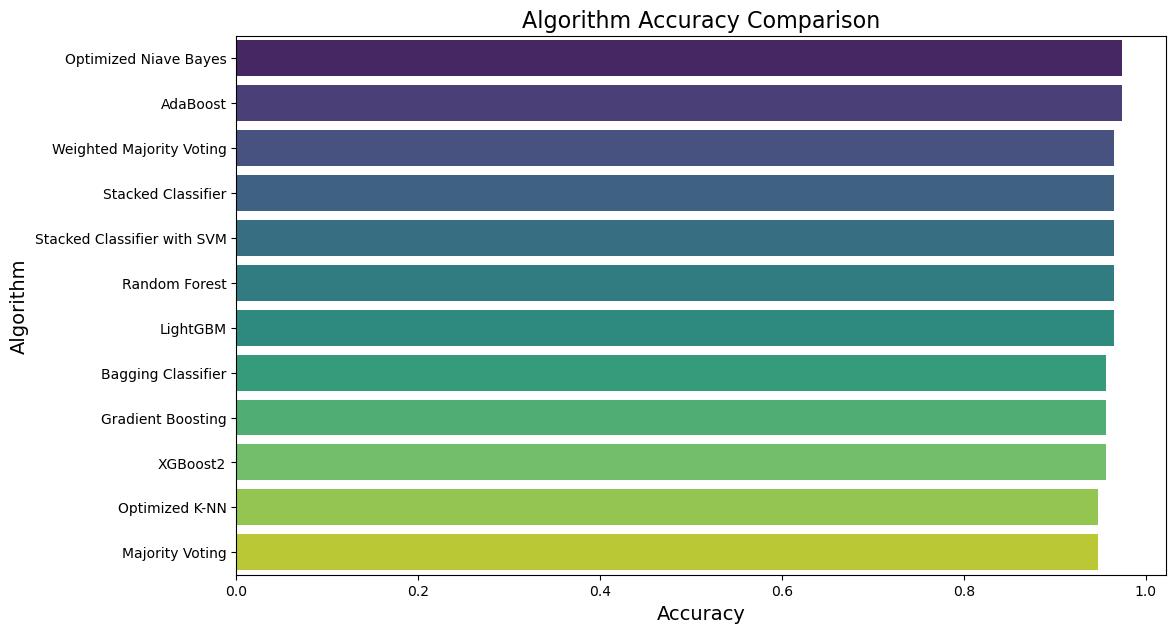

In [14]:
#ex8
#Compare performance from algorithms

# Set up the matplotlib figure
plt.figure(figsize=(12, 7))

# Sorting values for better visualization
sorted_names = sorted(alg_accuracy_scores, key=lambda x: alg_accuracy_scores[x], reverse=True)
sorted_scores = [alg_accuracy_scores[name] for name in sorted_names]

sns.barplot(x=sorted_scores, y=sorted_names, palette="viridis")

# Setting title and labels
plt.title('Algorithm Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Algorithm', fontsize=14)
plt.show()